# URA3 Data Analysis for AIPD TEVV (Ikonomova et al.)

## Load raw data and merge with *in silico* metrics

In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

In [ ]:
paraphrase = pd.read_csv("../data/selected_sequences.csv")
twist_ids= pd.read_csv('../data/ura3_plasmid_list_with_sequence.csv')

In [2]:
# Primary assay endpoint for score calculation
TIMEPOINT = '24:00:00'

In [9]:
def find_header_row(file_path, encoding='latin-1'):
    """
    Find the row number where the data header begins.
    
    Args:
        file_path: Path to CSV file
        encoding: File encoding (default: 'latin-1')
        
    Returns:
        Number of rows to skip for pd.read_csv
    """
    with open(file_path, 'r', encoding=encoding) as f:
        for i, line in enumerate(f):
            if line.strip() == "End Kinetic,":
                return i - 8
            #if line.startswith("Time,") or line.startswith('"Time",'):
            #    return i
    
    # Fallback to default if not found
    return 32

def parse_ura_exp(fname):
    """Parses single experiment run into df"""
    import pandas as pd
    import re
    
    header = find_header_row(fname)
    
    try:
        # Explicitly specify date_format to address the warning
        plate_data = pd.read_csv(fname,
                                encoding='latin-1',
                                header=header,
                                parse_dates=['Time'],
                                date_format='mixed'
                               )
    except Exception as e:
        print(f"Error parsing {fname}: {e}")
        # Try to read without date parsing as fallback
        plate_data = pd.read_csv(fname,
                                encoding='latin-1',
                                header=header
                               )
    
    plate_data = plate_data.set_index(plate_data.columns[0]).T

    ## Cleanup
    # Drop temperature row
    if 'T° 600' in plate_data.index:
        plate_data = plate_data.drop('T° 600')
    
    # Drop 700nm read data
    first_invalid_column = '700'

    # Get all column names before the first invalid column
    valid_columns = plate_data.columns.tolist()
    if first_invalid_column in valid_columns:
        cutoff_index = valid_columns.index(first_invalid_column)
        valid_columns = valid_columns[:cutoff_index]

    # Keep only the valid columns
    plate_data = plate_data[valid_columns].reset_index()
    
    fname_csv = re.sub(r'_Epoch\d+.txt', '.csv', fname)
    try:
        plate_map = pd.read_csv(fname_csv)
    except Exception as e:
        print(f"Error reading plate map {fname_csv}: {e}")
        raise  # Re-raise to halt processing if plate map can't be read

    return plate_data, plate_map

def annotate_exp(plate_data, plate_map):
    """Annotates raw data with plasmid and condition labels from plate map csv"""
    import pandas as pd
    
    # Check if the expected columns exist in both dataframes
    if 'index' not in plate_data.columns:
        print(f"Warning: 'index' column missing in plate_data. Columns: {plate_data.columns}")
    if 'well' not in plate_map.columns:
        print(f"Warning: 'well' column missing in plate_map. Columns: {plate_map.columns}")
    
    # Do the merge
    merged = pd.merge(plate_data, plate_map, left_on='index', right_on='well', how='left')
    
    # Check if media fraction columns exist
    if 'media_2_fraction' not in merged.columns:
        print(f"Warning: 'media_2_fraction' column missing after merge. Adding default.")
        merged['media_2_fraction'] = 0
    if 'media_4_fraction' not in merged.columns:
        print(f"Warning: 'media_4_fraction' column missing after merge. Adding default.")
        merged['media_4_fraction'] = 0
    
    # Ensure numeric types for media fraction columns
    merged['media_2_fraction'] = pd.to_numeric(merged['media_2_fraction'], errors='coerce').fillna(0)
    merged['media_4_fraction'] = pd.to_numeric(merged['media_4_fraction'], errors='coerce').fillna(0)
    
    return merged
    
def reduce_exp(annotated_data, timepoint=TIMEPOINT):
    """reduces data to single timepoint w/ exp conditions and plasmid/condition labels"""
    import pandas as pd
    
    # Verify we have required columns
    required_cols = ['plasmid', timepoint, 'media_2_fraction', 'media_4_fraction']
    for col in required_cols:
        if col not in annotated_data.columns:
            if col == timepoint:
                print(f"Warning: Timepoint '{timepoint}' not found. Available times: {[c for c in annotated_data.columns if ':' in str(c)]}")
                # Find an alternative timepoint column if the specified one isn't available
                time_cols = [c for c in annotated_data.columns if ':' in str(c)]
                if time_cols:
                    timepoint = time_cols[0]
                    print(f"Using alternative timepoint: {timepoint}")
                else:
                    raise ValueError(f"No time columns found in the data")
            else:
                print(f"Warning: Required column '{col}' not found in data. Available columns: {annotated_data.columns}")
                # Try to proceed anyway

    # Convert to numeric explicitly just to be sure
    annotated_data['media_2_fraction'] = pd.to_numeric(annotated_data['media_2_fraction'], errors='coerce').fillna(0)
    annotated_data['media_4_fraction'] = pd.to_numeric(annotated_data['media_4_fraction'], errors='coerce').fillna(0)
    
    # Use boolean mask instead of query to be more robust
    mask = (annotated_data['media_2_fraction'] == 1) | (annotated_data['media_4_fraction'] == 1)
    
    # Check if plasmid column exists
    if 'plasmid' not in annotated_data.columns:
        print("Warning: 'plasmid' column missing. Adding placeholder.")
        annotated_data['plasmid'] = 'unknown'
    
    result_cols = ['plasmid']
    if timepoint in annotated_data.columns:
        result_cols.append(timepoint)
    result_cols.extend(['media_2_fraction', 'media_4_fraction'])
    
    # Filter columns that actually exist in the dataframe
    existing_cols = [col for col in result_cols if col in annotated_data.columns]
    
    # Get the filtered data and reset the index to avoid issues when concatenating later
    filtered_data = annotated_data[mask][existing_cols]
    return filtered_data.reset_index(drop=True)

def get_all_exp(directory, pattern, recursive=False):
    """Lists files matching a pattern using glob."""
    import os
    import glob
    
    search_pattern = os.path.join(directory, pattern)
    if recursive:
        search_pattern = os.path.join(search_pattern, "**")
    return glob.glob(search_pattern, recursive=recursive)

def process_ura(fname):
    """Process a single URA experiment file with better error handling"""
    print(f"Processing {fname}")
    try:
        plate, plate_map = parse_ura_exp(fname)
        print(f"Successfully parsed data from {fname}")
        
        annotated = annotate_exp(plate, plate_map)
        print(f"Successfully annotated data from {fname}")
        
        reduced = reduce_exp(annotated)
        print(f"Successfully reduced data from {fname}")
        
        return reduced
    except Exception as e:
        print(f"Error processing {fname}: {e}")
        import traceback
        traceback.print_exc()
        # Return None or empty DataFrame instead of failing
        import pandas as pd
        return pd.DataFrame()

def process_all_ura_files(pattern, directory="."):
    """Process all URA experiment files matching the pattern"""
    import pandas as pd
    import os
    
    # Get all files
    files = get_all_exp(directory, pattern)
    print(f"Found {len(files)} files matching pattern")
    
    # Process each file
    experiments = []
    for fname in files:
        try:
            result = process_ura(fname)
            if not result.empty:
                # Add a source column to identify the experiment
                result['experiment_source'] = os.path.basename(os.path.dirname(fname))
                # Reset index to ensure no duplicate indices when concatenating
                if not result.index.is_unique:
                    print(f"Warning: Non-unique index in {fname}, resetting index")
                    result = result.reset_index(drop=True)
                experiments.append(result)
        except Exception as e:
            print(f"Failed to process {fname}: {e}")
    
    # Combine results
    if experiments:
        try:
            # Reset indices before concatenation to ensure no conflicts
            experiments = [exp.reset_index(drop=True) for exp in experiments]
            all_exp_data = pd.concat(experiments, ignore_index=True)
            return all_exp_data
        except Exception as e:
            print(f"Error during concatenation: {e}")

            print("Attempting alternative concatenation...")
            result_df = pd.DataFrame()
            for exp in experiments:
                try:
                    result_df = pd.concat([result_df, exp], ignore_index=True)
                except Exception as inner_e:
                    print(f"Failed to add experiment: {inner_e}")
            return result_df
    else:
        print("No valid experiment data found")
        return pd.DataFrame()


In [10]:
# Process all URA experiments in folder and concatenate results into single df
all_exp_data = process_all_ura_files("../data/assay/URA3/2025-*URA*/*growth-plate_1-2_Epoch*.txt")
all_exp_data[['plasmid', 'replicate']] = all_exp_data['plasmid'].str.rsplit('-', n=1, expand=True)

# Convert OD data to numeric
all_exp_data[TIMEPOINT] = pd.to_numeric(all_exp_data[TIMEPOINT], errors='coerce')

Found 12 files matching pattern
Processing ./../data/assay/URA3/2025-03-14_URA-assay_16-variants/2025-03-14_URA-assay_16-variants_growth-plate_1-2_Epoch1.txt
Successfully parsed data from ./../data/assay/URA3/2025-03-14_URA-assay_16-variants/2025-03-14_URA-assay_16-variants_growth-plate_1-2_Epoch1.txt
Successfully annotated data from ./../data/assay/URA3/2025-03-14_URA-assay_16-variants/2025-03-14_URA-assay_16-variants_growth-plate_1-2_Epoch1.txt
Successfully reduced data from ./../data/assay/URA3/2025-03-14_URA-assay_16-variants/2025-03-14_URA-assay_16-variants_growth-plate_1-2_Epoch1.txt
Processing ./../data/assay/URA3/2025-01-25_URA-assay_16-variants/2025-01-25_URA-assay_16-variants_growth-plate_1-2_Epoch2.txt
Successfully parsed data from ./../data/assay/URA3/2025-01-25_URA-assay_16-variants/2025-01-25_URA-assay_16-variants_growth-plate_1-2_Epoch2.txt
Successfully annotated data from ./../data/assay/URA3/2025-01-25_URA-assay_16-variants/2025-01-25_URA-assay_16-variants_growth-plate

## Labeling/Filtering

Significance testing with one-tailed Welch's t-tests.
For this experiment, WT in SD-Trp-Ura = dead (plasmid expression, no induction)

In [11]:
ura_results_rel = all_exp_data.query('media_4_fraction == 1.00')
ura_results_nc = all_exp_data.query("media_2_fraction == 1.00  and plasmid == 'URA3_34'")
ura_results_nc['plasmid'] = "URA3_NC"
ura_results_rel = pd.concat([ura_results_rel, ura_results_nc])

/var/folders/kv/drkyrlls1gjbt2hggx0nyrb40023dp/T/ipykernel_6345/4106668826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ura_results_nc['plasmid'] = "URA3_NC"


In [13]:
def significance_test(df, a, labels, values, threshold=0.05):
    """
    Perform significance testing between a specified condition and all other conditions,
    distinguishing between conditions significantly greater than the reference.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data
    a : str
        The reference condition to compare against others
    labels : str
        Column name containing condition labels
    values : str
        Column name containing the measurement values
    threshold : float, default=0.05
        P-value threshold for determining significance
        
    Returns:
    --------
    pandas.DataFrame
        Summary dataframe with statistics and significance results including 'active' status
    """
    # Extract the reference condition data
    a_values = df[df[labels] == a][values].dropna().values
    a_mean = np.mean(a_values)
    
    # Get unique labels excluding the reference condition
    unique_labels = df[labels].unique()
    
    # Initialize lists to store results
    result_labels = []
    means = []
    sds = []
    p_values = []
    significants = []
    actives = []
    
    # Process each label
    for label in unique_labels:
        # Extract values for current label
        label_values = df[df[labels] == label][values].dropna().values
        
        # Calculate mean and standard deviation
        mean_value = np.mean(label_values)
        sd_value = np.std(label_values, ddof=1)  # Using sample standard deviation
        
        # Perform t-test if not comparing the condition to itself
        if label != a:
            # One-sided t-test to check if mean is greater than reference
            _, p_value = stats.ttest_ind(label_values, a_values, equal_var=False, alternative='greater')
        else:
            p_value = 1.0  # Same condition, so p-value is 1
        
        # Determine significance for two-sided test
        significant = p_value < threshold
        
        # Determine if the condition is significantly greater than reference (active)
        # Only mark as active if the one-sided test is significant
        active = p_value < threshold and mean_value > a_mean
        
        # Append results
        result_labels.append(label)
        means.append(mean_value)
        sds.append(sd_value)
        p_values.append(p_value)
        significants.append(significant)
        actives.append(active)
    
    # Create and return the summary dataframe
    summary_df = pd.DataFrame({
        'plasmid': result_labels,
        'mean_value': means,
        'sd_value': sds,
        'p_value': p_values,
        'significant': significants,
        'active': actives
    })
    
    return summary_df

In [14]:
# Apply the stats function
signif = significance_test(ura_results_rel, 'URA3_NC', 'plasmid', '24:00:00', 0.05)

## Plotting raw data
Plotting pre-normalization

In [17]:
def label(df, labels_col, missing_col, key):
    """
    Add missing labels to a pandas column based on pattern matching.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    labels_col : str
        Column name containing patterns to match
    missing_col : str
        Column name to populate with new labels
    key : dict
        Dictionary mapping patterns to labels
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with missing_col populated based on pattern matching
    """
    new_df = df.copy()
    
    # For each pattern and label in the key
    for pattern, label in key.items():
        # Find rows where labels_col contains the pattern
        mask = new_df[labels_col].str.contains(pattern, na=False)
        
        # Update missing_col with the label where the mask is True
        new_df.loc[mask, missing_col] = label
    
    return new_df

In [ ]:
# Create plotting df

# Extract Twist IDs
ura_results_rel['extracted_id'] = ura_results_rel['plasmid'].str.extract(r'_([^-]+)')
# Merge the DataFrames based on the extracted ID and Well Location
raw_plot_df = pd.merge(
    ura_results_rel,
    twist_ids[['Well Location', 'Name']],  # Only select the columns we need
    left_on='extracted_id',                # Column from results_df
    right_on='Well Location',              # Column from labels_df
    how='left'                             # Keep all rows from results_df
)

# Step 3: Clean up
raw_plot_df['Name'] = raw_plot_df['Name'].str.replace('_M1$', '', regex=True)

# Step 4: Merge the experimental data onto the paraphrase data
raw_plot_df.rename(columns={'Name': 'selected_name'}, inplace=True)

In [20]:
# Append labels missing in plasmid list (controls, plate 2)
key = {
    "URA3_WT": "WT",
    "URA3_05": "R235A",
    "URA3_34": "Q215A",
    "URA3_P2-A1": "ura3_96",
    "URA3_P2-B1": "ura3_97",
    "URA3_P2-C1": "ura3_98",
    "URA3_P2-D1": "ura3_99",
    "URA3_NC": "NC"
}

raw_plot_df = label(raw_plot_df, "plasmid", "selected_name", key)

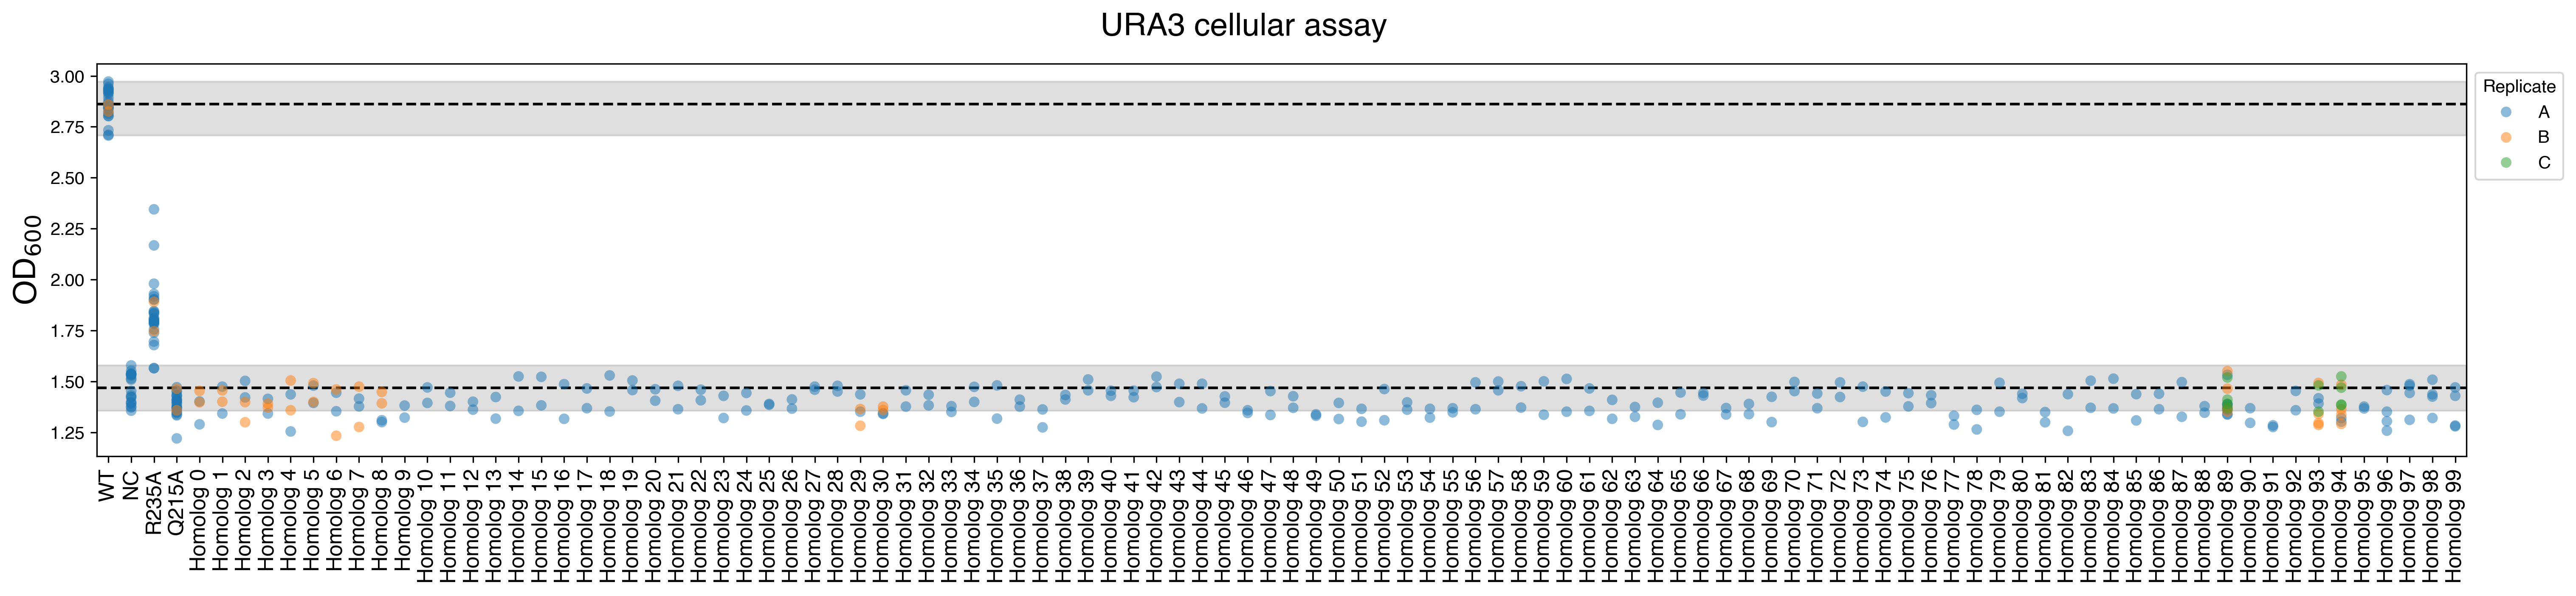

In [25]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = [24, 4]

fig, ax = plt.subplots()
fig.suptitle('URA3 cellular assay', size=18)

df = raw_plot_df.copy()
df = label(df, "plasmid", "selected_name", key)

df['selected_name'] = df['selected_name'].str.replace('ura3_', 'Homolog ')
df = df.sort_values(by='replicate')

wt_df = df[df['selected_name'] == 'WT']

wt_mean = wt_df['24:00:00'].mean()
wt_min = wt_df['24:00:00'].min()
wt_max = wt_df['24:00:00'].max()
nc_mean = ura_results_nc['24:00:00'].mean()
nc_min = ura_results_nc['24:00:00'].min()
nc_max = ura_results_nc['24:00:00'].max()

df = df.rename(columns={'replicate': 'Replicate'})

order = ["WT", "NC", "R235A", "Q215A"] + list(f"Homolog {i}" for i in range(100))

g = sns.stripplot(ax=ax,
                  data=df,
                  x="selected_name",
                  y="24:00:00",
                  size=6,
                  native_scale=False,
                  hue='Replicate',
                  alpha=0.5,
                  jitter=0,
                  order=order)
ax.set_ylabel('OD$_{600}$', size=18)
ax.set_xlabel('');

#ax.tick_params(axis='x', labelrotation=45, ha='right');
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, size=12);#, ha='right', rotation_mode='anchor');
xlim = ax.get_xlim()
ax.set_xlim(xlim)
for y, ymin, ymax in zip([wt_mean, nc_mean], [wt_min, nc_min], [wt_max, nc_max]):
    ax.plot(xlim, [y]*2, '--k');
    ax.fill_between(xlim, [ymax]*2, [ymin]*2, color='gray', alpha=0.25, zorder=-20)
#ax.set_ylim(0, 2.1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

## Normalization and data export

In [27]:
# Extract Twist IDs
signif['extracted_id'] = signif['plasmid'].str.extract(r'_([^-]+)')

# Merge the DataFrames based on the extracted ID and Well Location
merged_df = pd.merge(
    signif,
    twist_ids[['Well Location', 'Name']],  # Only select the columns we need
    left_on='extracted_id',                # Column from results_df
    right_on='Well Location',              # Column from labels_df
    how='left'                             # Keep all rows from results_df
)

# Cleanup
merged_df = merged_df.drop(['extracted_id', 'Well Location'], axis=1)
# Remove M1 (methionine in position 1) from homolog names
merged_df['Name'] = merged_df['Name'].str.replace('_M1$', '', regex=True)

# Merge
merged_df.rename(columns={'Name': 'selected_name'}, inplace=True)

normalized_df = merged_df.copy()

key = {
    "URA3_WT": "WT",
    "URA3_05": "R235A",
    "URA3_34": "Q215A",
    "URA3_P2-A1": "ura3_96",
    "URA3_P2-B1": "ura3_97",
    "URA3_P2-C1": "ura3_98",
    "URA3_P2-D1": "ura3_99",
    "URA3_NC": "NC"
}

normalized_df = label(normalized_df, "plasmid", "selected_name", key)

# Normalization
nc = normalized_df[normalized_df['plasmid'] == 'URA3_34']['mean_value'].mean()
normalized_df['score'] = normalized_df['mean_value'] - nc

wt_mean = normalized_df[normalized_df['plasmid'] == 'URA3_WT']['score'].mean()
normalized_df['score'] = normalized_df['score'] / wt_mean

In [28]:
experimental_merge = pd.merge(paraphrase, normalized_df, on='selected_name')
experimental_merge.to_csv('../data/output/ura3_insilico_merged.csv')

## Plotting assay results (normalized)

In [31]:
# Collect hits/plot
df_plot = experimental_merge.groupby('selected_name')[['dplddt_mean', 'tm_mean', 'seqid', 'score', 'active']].mean()
df_plot = df_plot.dropna(subset=['dplddt_mean', 'tm_mean', 'seqid'])

shape_mapping = df_plot['active'].apply(lambda x: 'o' if x == 1.0 else 'x')
#edge_mapping = df_plot['active'].apply(lambda x: 'black' if x == 1.0 else [0, 0, 0, 0])

x, y, z = df_plot['dplddt_mean'], df_plot['tm_mean'], df_plot['seqid']

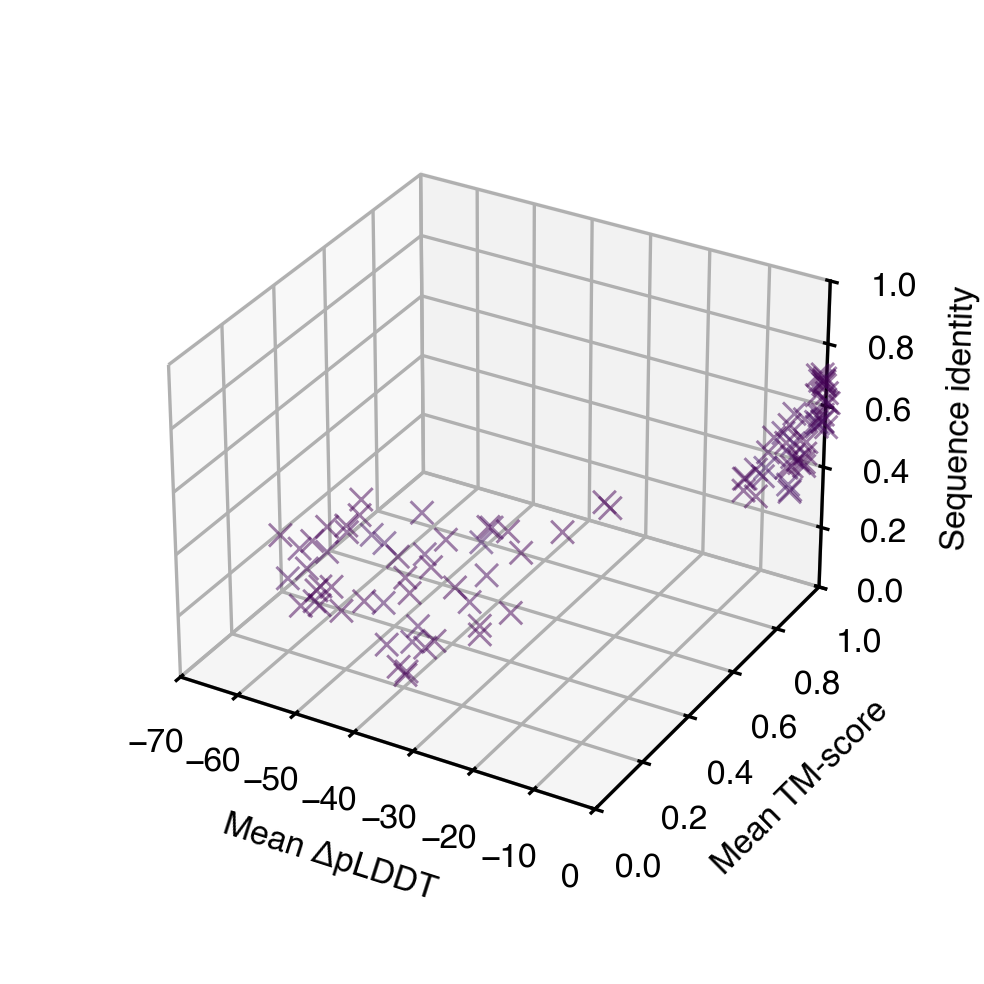

In [32]:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 8})
font = {'fontname':'Helvetica'}

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect(None, zoom=0.80)
ax.set_xlabel('Mean ΔpLDDT')
ax.set_xlim(-70, 0)
ax.set_ylabel('Mean TM-score')
ax.set_ylim(0, 1)
ax.set_zlabel('Sequence identity')
ax.set_zlim(0, 1)

# plot a 3D surface like in the example mplot3d/surface3d_demo
cmap = sns.color_palette("viridis", as_cmap=True)
# Clip color mapping to [0,1]
vmin = 0
vmax = 1
for shape in np.unique(shape_mapping):
    mask = shape_mapping == shape
    surf = ax.scatter(x[mask], y[mask], z[mask],
                    s=30,
                    alpha=0.5,
                    c=df_plot.loc[mask, 'score'],
                    marker=shape,
                    #edgecolors=edge_mapping[mask],
                    linewidths=0.7,
                    cmap=cmap,
                    vmin=vmin,
                    vmax=vmax,
                    )

ax.set_zlim(0, 1.0)
#fig.colorbar(surf, shrink=0.3, aspect=10)

# Get the current y and z limits
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()

plt.show()

## BLAST flagging

In [34]:
blast = pd.read_csv("../data/blast/ura3_blast_results.csv")
blast['query_sequence'] = blast['query_sequence'].str.replace('_M1', '')
blast = pd.merge(blast, experimental_merge, left_on='query_sequence', right_on='selected_name')

In [37]:
### Flagger function

from Bio import Entrez

import requests
import time
from bs4 import BeautifulSoup

# Function to fetch the metadata from the PDB landing page
def fetch_pdb_metadata_from_web(pdb_id):
    url = f"https://www.rcsb.org/structure/{pdb_id}"
    time.sleep(1)
    response = requests.get(url)
    
    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract the title of the structure
        title = soup.find('span', id='structureTitle').get_text(strip=True)
        
        # Extract the description/annotations (generally in the first paragraph or under a specific div)
        description_div = soup.find('div', class_='abstract')
        if description_div:
            description = description_div.get_text(strip=True)
        else:
            description = "No description available."
        
        return title, description
    else:
        print(f"Failed to fetch PDB {pdb_id}. HTTP Status: {response.status_code}")
        return None, None

def fetch_ncbi_record(query,
                      keyword="decarboxylase",
                      email="geoffrey.taghon@nist.gov"):
    """
    Fetch an NCBI record using an accession number, regardless of database source.
    
    Parameters:
    accession (str): The accession number (e.g., 'NM_123456', 'XM_123456', 'KY123456')
    email (str): Your email address for NCBI API access
    
    Returns:
    A SeqRecord object containing the fetched record
    """
    Entrez.email = email

    # If no top match, no flag
    if pd.isna(query):
        return False
    else:
        database, accession = str(query).split("|")[0], str(query).split("|")[1]

    # If PDB hit, handle differently
    if database == "pdb":
        title, description = fetch_pdb_metadata_from_web(accession)
        if keyword in title:
            return True
    
    # First, try to get the record from nucleotide database (covers most types)
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="xml", retmode="xml")
        record = handle.read()
        handle.close()
        if keyword in str(record):
            return True
    except Exception as e:
        print(f"Couldn't fetch from nucleotide database: {e}")
    
    # If that fails, try the protein database
    try:
        handle = Entrez.efetch(db="protein", id=accession, rettype="xml", retmode="xml")
        record = handle.read()
        handle.close()
        if keyword in str(record):
            return True
    except Exception as e:
        print(f"Couldn't fetch from protein database: {e}")
    
    # If both fail, try to search for the accession across databases
    try:
        # Use esearch to find which database the accession belongs to
        search_handle = Entrez.esearch(term=accession, retmax=1)
        search_results = Entrez.read(search_handle)
        search_handle.close()
        
        if search_results["Count"] != "0":
            record_id = search_results["IdList"][0]
            # Try to fetch using the found ID
            handle = Entrez.efetch(id=record_id, rettype="xml", retmode="xml")
            record = handle.read()
            handle.close()
        if keyword in str(record):
            return True
    except Exception as e:
        print(f"Couldn't find the accession in any database: {e}")
    
    return False

if not os.path.exists('../data/output/ura3_blast_flags.csv'):
    blast['flagged'] = blast['top_match'].apply(fetch_ncbi_record)
    blast.to_csv("../data/output/ura3_blast_flags.csv")

## Plotting BLAST confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def plot_confusion_matrix(y_true, y_pred, figsize=(4, 5), cmap='Blues', title='URA3'):
    """
    Create a visually appealing confusion matrix plot from two boolean series.
    
    Parameters:
    y_true (pd.Series or array-like): Series of actual values (TRUE/FALSE)
    y_pred (pd.Series or array-like): Series of predicted values (TRUE/FALSE)
    figsize (tuple): Figure size as (width, height)
    cmap (str): Colormap for the heatmap
    title (str): Title for the plot
    
    Returns:
    matplotlib.figure.Figure: The figure object
    """
    # Ensure inputs are boolean
    y_true = pd.Series(y_true).astype(bool)
    y_pred = pd.Series(y_pred).astype(bool)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap=cmap,
        vmin=0,
        vmax=len(blast),
        linewidths=.5,
        square=True,
        cbar=False,
        annot_kws={"size": 32},
        ax=ax
    )
    
    # Labels, title and ticks
    ax.set_xlabel('Flagged by BLAST', fontsize=14, labelpad=10)
    ax.set_ylabel('Above threshold', fontsize=14, labelpad=10)
    ax.set_title(title, fontsize=16, pad=20)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    # Set custom x and y tick labels
    ax.set_xticklabels(['–', '+'], fontsize=22)
    ax.set_yticklabels(['–', '+'], fontsize=22, rotation=0)
    
    # Add text annotations for the cells with descriptive labels
    categories = ['True negative', 'False positive', 'False negative', 'True positive']
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    for i, (pos_y, pos_x) in enumerate(positions):
        ax.text(
            pos_x + 0.5, 
            pos_y + 0.85, 
            categories[i],
            horizontalalignment='center',
            size=14,
            color='black' if cm[pos_y, pos_x] < (len(blast) / 2) else 'white'
        )
    
    # Add metrics as text below the matrix
    """
    plt.figtext(0.5, 0.01, 
                f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1 Score: {f1:.3f}',
                ha="center", 
                fontsize=12, 
                bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    """
    
    plt.tight_layout()

/usr/local/Caskroom/miniconda/base/envs/clip-search/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


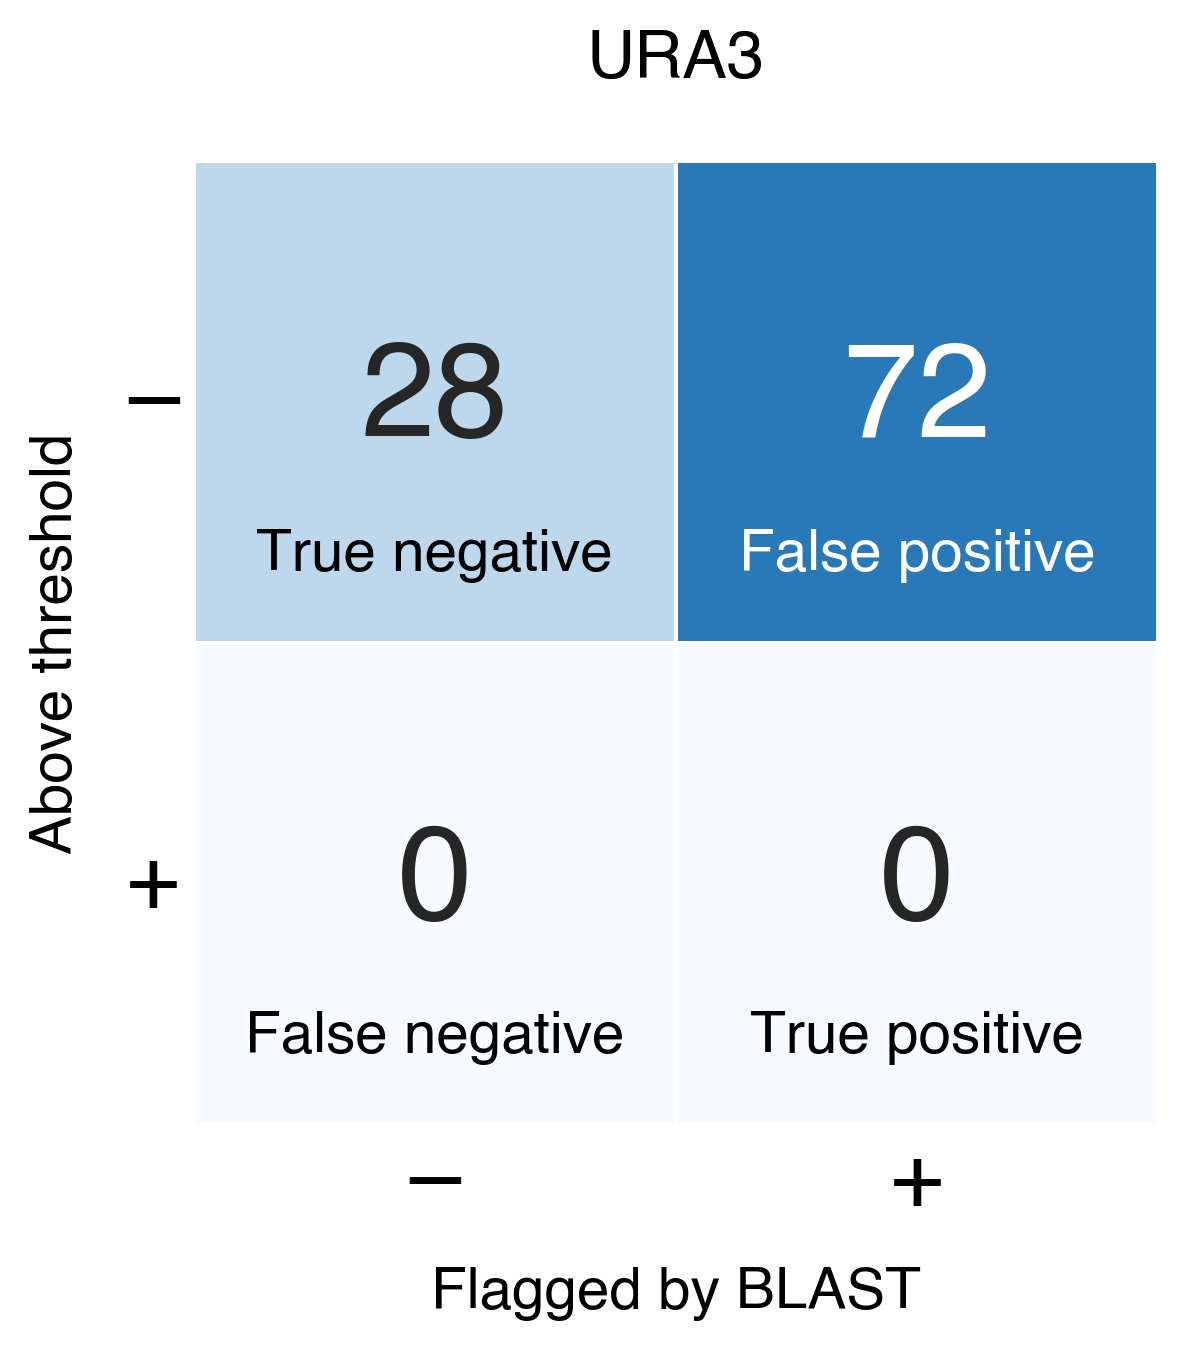

In [39]:
blast = pd.read_csv('../data/output/ura3_blast_flags.csv')

plot_confusion_matrix(blast['active'], blast['flagged'])